In [88]:
import pyarrow.parquet as pq
import pandas as pd
from datetime import datetime

In [54]:
odx_formated = pq.read_table('October 19/tmstp_oct_odx.snappy.parquet', columns = ['trans_status_key', 'boarding_stop', 'inferred_alighting_gtfs_stop', 'transfer_inference',
                        'journey_size', 'transaction_dtm', 'alighting_time'])
odx_df = odx_formated.to_pandas()

trips = odx_df.loc[odx_df['trans_status_key']==0]
trips = trips.reset_index(drop=True)


In [55]:
trips['str_transTime'] = trips['transaction_dtm'].astype(str)
new = trips["str_transTime"].str.split(" ", n = 1, expand = True) 
trips["trans_date"]= new[0] 
trips["trans_time"]= new[1] 

trips['str_alightTime'] = trips['alighting_time'].astype(str)
temp = trips["str_alightTime"].str.split(" ", n = 1, expand = True) 
trips["alight_date"]= temp[0] 
trips["alight_time"]= temp[1] 

trips = trips.loc[trips['trans_date']=='2017-10-19']  #data includes both 10/19 and 10/20 - extract for only 10/19

In [58]:
trans_trips = trips.loc[trips['journey_size']>1]
trans_trips = trans_trips.reset_index(drop=True)

In [66]:
direct_trips = trips.loc[trips['journey_size']==1]
direct_trips = direct_trips.loc[direct_trips['alight_date']=='2017-10-19']
direct_trips = direct_trips.loc[direct_trips['transfer_inference']=='Destination']
direct_trips = direct_trips.reset_index(drop=True)

(254037, 13)


In [67]:
print(trips.shape)
print(direct_trips.shape)
print(trans_trips.shape)

(1389853, 13)
(254037, 13)
(394975, 13)


In [78]:
#number of destinations in transfer trips
trans_test = trans_trips.loc[trans_trips['alight_date']=='2017-10-19']
num_dests = trans_trips.loc[trans_trips['transfer_inference']=='Destination']
test_num = trans_test.loc[trans_trips['transfer_inference']=='Destination']
print(trans_test.shape)
print(num_dests.shape)
print(test_num.shape)

(266402, 13)
(182418, 13)
(114381, 13)


In [71]:
# Direct Trips 
ODX_trips = {'origin':[], 'dest':[], 'dep_time':[], 'arr_time':[], 'transfers':[], 'travel_time':[]}

rows = direct_trips.shape[0]
for i in range(rows):
    trans = direct_trips['journey_size'][i]
    trans_inference = direct_trips['transfer_inference'][i]
    
    #single ride trip: origin -> destination
    if (trans==1 and trans_inference =='Destination'):
        ODX_trips['origin'].append(direct_trips['boarding_stop'][i])
        ODX_trips['dest'].append(direct_trips['inferred_alighting_gtfs_stop'][i])
        ODX_trips['dep_time'].append(direct_trips['transaction_dtm'][i])
        ODX_trips['arr_time'].append(direct_trips['alighting_time'][i])
        ODX_trips['transfers'].append(trans - 1)

        alighting_time = direct_trips['alighting_time'][i]
        trans_time = direct_trips['transaction_dtm'][i]
        
        if (type(alighting_time) is pd.Timestamp):
            diff = (alighting_time - trans_time).seconds
            ODX_trips['travel_time'].append(diff)
        else:
            ODX_trips['travel_time'].append(None)
    
    #check for errors:
    if len(ODX_trips['origin'])!=len(ODX_trips['dest']): print(i)


{'origin': [], 'dest': [], 'dep_time': [], 'arr_time': [], 'transfers': [], 'travel_time': []}


In [72]:
print(len(ODX_trips['origin']))
print(len(ODX_trips['dest']))
print(len(ODX_trips['dep_time']))
print(len(ODX_trips['arr_time']))
print(len(ODX_trips['transfers']))
print(len(ODX_trips['travel_time']))


254037
254037
254037
254037
254037
254037


In [83]:
# Transfer Trips
ODX_trans_trips = {'origin':[], 'dest':[], 'dep_time':[], 'arr_time':[], 'transfers':[], 'travel_time':[]}

row = trans_trips.shape[0]
print(ODX_trans_trips)
counter = 0
for i in range(row):
    trans = trans_trips['journey_size'][i]
    trans_inference = trans_trips['transfer_inference'][i]
    
    #trip containing transfers
    if (trans > 1 and i>0):
        dep_time = trans_trips['transaction_dtm'][i]
        
        if (trans_trips['transfer_inference'][i-1] == 'Destination' and trans_inference == 'Transfer'): #must be a new Origin of trip
            ODX_trans_trips['origin'].append(trans_trips['boarding_stop'][i])
            ODX_trans_trips['dep_time'].append(dep_time)

        if (trans_inference == 'Destination' and trans_trips['transfer_inference'][i-1] == 'Transfer'):
            ODX_trans_trips['dest'].append(trans_trips['inferred_alighting_gtfs_stop'][i])
            ODX_trans_trips['transfers'].append(trans - 1)
            
            if (trans_trips['alight_date'][i]=='2017-10-19'):
                ODX_trans_trips['arr_time'].append(trans_trips['alighting_time'][i])

                alighting_time = trans_trips['alighting_time'][i]
            
                if (type(alighting_time) is pd.Timestamp):
                    diff = (alighting_time - dep_time).seconds
                    ODX_trans_trips['travel_time'].append(diff)
                else:
                    ODX_trans_trips['travel_time'].append(None)
            else:
                counter += 1
                ODX_trans_trips['arr_time'].append(None)
                ODX_trans_trips['travel_time'].append(None)

    elif (trans>1 and i==0):
        dep_time = trans_trips['transaction_dtm'][i]
        ODX_trans_trips['origin'].append(trans_trips['boarding_stop'][i])
        ODX_trans_trips['dep_time'].append(dep_time)
        
    #check for errors:
    if len(ODX_trans_trips['origin']) - len(ODX_trans_trips['dest']) >= trans: print(i)
        
print(counter)

{'origin': [], 'dest': [], 'dep_time': [], 'arr_time': [], 'transfers': [], 'travel_time': []}
68037


In [84]:
print(len(ODX_trans_trips['origin']))
print(len(ODX_trans_trips['dest']))
print(len(ODX_trans_trips['dep_time']))
print(len(ODX_trans_trips['arr_time']))
print(len(ODX_trans_trips['transfers']))
print(len(ODX_trans_trips['travel_time']))

182418
182418
182418
182418
182418
182418


In [85]:
ODX_trips_all = {'origin':[], 'dest':[], 'dep_time':[], 'arr_time':[], 'transfers':[], 'travel_time':[]}

ODX_trips_all['origin'].extend(ODX_trips['origin'])
ODX_trips_all['dest'].extend(ODX_trips['dest'])
ODX_trips_all['dep_time'].extend(ODX_trips['dep_time'])
ODX_trips_all['arr_time'].extend(ODX_trips['arr_time'])
ODX_trips_all['transfers'].extend(ODX_trips['transfers'])
ODX_trips_all['travel_time'].extend(ODX_trips['travel_time'])

ODX_trips_all['origin'].extend(ODX_trans_trips['origin'])
ODX_trips_all['dest'].extend(ODX_trans_trips['dest'])
ODX_trips_all['dep_time'].extend(ODX_trans_trips['dep_time'])
ODX_trips_all['arr_time'].extend(ODX_trans_trips['arr_time'])
ODX_trips_all['transfers'].extend(ODX_trans_trips['transfers'])
ODX_trips_all['travel_time'].extend(ODX_trans_trips['travel_time'])

print(len(ODX_trips_all['origin']))
print(len(ODX_trips_all['dest']))
print(len(ODX_trips_all['dep_time']))
print(len(ODX_trips_all['arr_time']))
print(len(ODX_trips_all['transfers']))
print(len(ODX_trips_all['travel_time']))

436455
436455
436455
436455
436455
436455


In [86]:
ODX_final_trips = pd.DataFrame(ODX_trips_all)
ODX_final_trips = ODX_final_trips.dropna()
ODX_final_trips = ODX_final_trips.reset_index(drop=True)
ODX_final_trips.to_csv('1019_trips_filtered.csv')
ODX_final_trips.shape

In [89]:
'''
MATCH TRIPS
'''
import sqlite3
import geopandas as gpd
import math

input_origins = pd.read_csv("input_origins.csv")
input_dests = pd.read_csv("input_dests.csv")
odx_data = ODX_final_trips

stops_geo = pd.read_csv("./ODX_files/PT_2017-10-10_stops.csv")
census_tracts = pd.read_csv("census_tracts_bounded.csv")


In [90]:
'''
CREATE AND CONNECT TO LOCAL DATABASE OF ODX TRIP DATA
'''
od_trips_db = "od_trips.db"    # database of filtered ODX trips: origin, destination, depart_time, arr_time, transfers, travel_time
conn = sqlite3.connect(od_trips_db)  # connect to that database (will create if it doesn't already exist)
c = conn.cursor()  # make cursor into database (allows us to execute commands)
c.execute('''CREATE TABLE IF NOT EXISTS od_trips (origin int, dest int, dep_time timestamp, arr_time timestamp, transfers int, travel_time int, UNIQUE(origin, dest, dep_time, arr_time, transfers, travel_time));''') # run a CREATE TABLE command

mylen = odx_data.shape[0]
for i in range(mylen):
    org = int(odx_data['origin'][i])        #must typecast ints in sql or it will be represented as binary
    dest = int(odx_data['dest'][i])
    
    dep_time = odx_data['dep_time'][i].to_pydatetime()
    arr_time = odx_data['arr_time'][i].to_pydatetime()
    
    trans = int(odx_data['transfers'][i])
    tt = int(odx_data['travel_time'][i])
    c.execute('''INSERT OR IGNORE into od_trips VALUES (?,?,?,?,?,?);''',(org,dest,dep_time,arr_time,trans,tt))

conn.commit() # commit commands
conn.close() # close connection to database


In [92]:
'''
add column to input OD pairs of geoid of census tract it is in
'''
from shapely.geometry import Point
from shapely import wkt

census_tracts['geometry'] = census_tracts['geometry'].apply(wkt.loads)
cgdf = gpd.GeoDataFrame(census_tracts, geometry = 'geometry')

start_tract_id_col = []
end_tract_id_col = []

mylen = input_origins.shape[0]

for i in range(mylen):
    p_start = Point(input_origins['X'][i], input_origins['Y'][i])
    p_end = Point(input_dests['X'][i], input_dests['Y'][i])
    start_tract = 0
    end_tract = 0

    #loop through census_tracts
    for i in range(801):
        geometry = cgdf['geometry'][i]
        if (p_start.within(geometry)):
            start_tract = cgdf['geoid10'][i]
        if (p_end.within(geometry)):
            end_tract = cgdf['geoid10'][i]

    #append corresponding tract ids to row in OD_pairs dataframe
    start_tract_id_col.append(start_tract)
    end_tract_id_col.append(end_tract)

# cast the two geo_id columns into dataframes and append to OD_pairs
start_col = pd.DataFrame(start_tract_id_col, columns = ['start_tract'])
end_col = pd.DataFrame(end_tract_id_col, columns = ['end_tract'])
input_origins = pd.concat([input_origins, start_col], axis=1)
input_dests = pd.concat([input_dests, end_col], axis=1)

In [93]:
'''
SUPPORTING FUNCTION: CALCULATE LON/LAT MIN&MAX BOUNDS GIVEN A GEO-COORDINATE
- cast coordinate into corresponding census tract bounds calculated by geobounds.py and stored in census_tracts_bounded.csv
'''
def bounds(tract_geoid):
    tract = census_tracts.loc[census_tracts['geoid10'] == tract_geoid]
    if tract.empty:
        return None
    return (tract['minx'].iloc[0], tract['maxx'].iloc[0], tract['miny'].iloc[0], tract['maxy'].iloc[0])


In [94]:
'''
CREATE AND CONNECT A LOCAL DATABASE OF TRANSIT STOPS AND CORRESPONDING LON/LAT
* note: only unique stop_id in the database
** Only need to run this snippet once, comment out later to save time
'''
stops_db = "stops.db"
conn_s = sqlite3.connect(stops_db)
c_s = conn_s.cursor()
c_s.execute('''CREATE TABLE IF NOT EXISTS stops (stop_id int UNIQUE, stop_lat float, stop_lon float);''')

mylen = stops_geo.shape[0]
for i in range(mylen):
    id = int(stops_geo['stop_id'][i])
    lat = stops_geo['stop_lat'][i]
    lon = stops_geo['stop_lon'][i]
    c_s.execute('''INSERT OR IGNORE into stops VALUES (?,?,?);''',(id, lat, lon))

conn_s.commit()
conn_s.close()

In [95]:
'''
OD PAIR -> ODX TRIP MATCHING
1. For each Origin-Destination pair, get all stops in same tract as the origin,
    and another set of stops in same tract as the destination coordinate
2. Find all trips in ODX database that match origin and destination id
3. Sort matching trips by travel time and calculate 75th percentile and median travel time
4. Store in results_travel_time local database (can easily be extracted and converted to pandas dataframe/csv)
'''
conn_s = sqlite3.connect(stops_db)
c_s = conn_s.cursor()

conn = sqlite3.connect(od_trips_db)         
c = conn.cursor()

results_db = "results.db"
conn_results = sqlite3.connect(results_db)
c_r = conn_results.cursor()
c_r.execute('''CREATE TABLE IF NOT EXISTS results_travel_time (time_start int, time_end int, start_lat float, start_lon float, end_lat float, end_lon float, start_stop int, end_stop int, transfers int, median_tt int, quartile_tt int, UNIQUE(time_start, time_end, start_lat, start_lon, end_lat, end_lon, start_stop, end_stop, transfers, median_tt, quartile_tt));''')


OD_pairs_len = input_origins.shape[0]

#Iterate through each desired Origin-Destination pair
for i in range(OD_pairs_len):
    print(i)

    #extract origin and destination lat/lon in geo coordinates
    or_lat = input_origins['Y'][i]
    or_lon = input_origins['X'][i]
    dest_lat = input_dests['Y'][i]
    dest_lon = input_dests['X'][i]
    start_id = input_origins['start_tract'][i]
    end_id = input_dests['end_tract'][i]
    
    #print(or_lat, or_lon, dest_lat, dest_lon)
    
    # get min&max bounds on lat/lon given desired radius (lat_min, lat_max, lon_min, lon_max)
    origin_bounds = bounds(start_id)
    dest_bounds = bounds(end_id)
    
    #print('origin bounds', origin_bounds)
    #print('dest bounds', origin_bounds)
    
    # case where origin or destination coordinates are not in a census tract
    if origin_bounds is None or dest_bounds is None:
        c_r.execute('''INSERT OR IGNORE into results_travel_time VALUES (?,?,?,?,?,?,?,?,?,?,?);''',(28800, 28800, or_lat, or_lon, dest_lat, dest_lon, None, None, None, None, None))
    else:
        query = (
            '''
            SELECT * FROM stops WHERE
                (stop_lon > ? AND stop_lon < ?) AND (stop_lat > ? AND stop_lat < ?);
            '''
            )
        
        # get a list of stops within census tract
        or_neighbors = c_s.execute(query, origin_bounds).fetchall()
        dest_neighbors = c_s.execute(query, dest_bounds).fetchall()
        
        
        # Find all possible trips in ODX database that match neighboring origin and destination id
        matching_trips = []
        for origin in or_neighbors:
            for dest in dest_neighbors:
                matching_OD = c.execute(
                    '''SELECT * FROM od_trips WHERE origin = ? AND dest = ?;''',
                    (origin[0], dest[0])).fetchall()
                
                if matching_OD:
                    for trip in matching_OD:
                        dep_dt = datetime.strptime(trip[2], '%Y-%m-%d %H:%M:%S')
                        if abs(dep_dt.hour - 8) < 2:
                            matching_trips.append(trip)

        conn.commit()
        conn_s.commit()
        
        
        if (len(matching_trips)>0):
            #print('within-one hour',i, matching_trips)
            
            matching_trips.sort(key = lambda x: x[5])
            quartile_index = math.floor(0.75*len(matching_trips))   #75th percentile index
            median_index = math.floor(0.5*len(matching_trips))      #median index
            q_trip = matching_trips[quartile_index]
            m_trip = matching_trips[median_index]
            
            c_r.execute('''INSERT OR IGNORE into results_travel_time VALUES (?,?,?,?,?,?,?,?,?,?,?);''',(q_trip[2], q_trip[3], or_lat, or_lon, dest_lat, dest_lon, q_trip[0], q_trip[1], q_trip[4], m_trip[5], q_trip[5]))


        conn_results.commit()

            
# Uncomment to visualize results
# res = c_r.execute('''SELECT * FROM results_travel_time''').fetchall()
# for trip in res:
#    print('mytrip', i, trip)



conn_results.close()
conn.close()
conn_s.close()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064


3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703


5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346


6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987


In [96]:
'''
Convert Results Database to Python Dataframe for analysis
'''
cnx = sqlite3.connect("results.db")
results = pd.read_sql_query("SELECT * FROM results_travel_time", cnx)

In [97]:
print(results.shape[0], results.dtypes)

4591 time_start      object
time_end        object
start_lat      float64
start_lon      float64
end_lat        float64
end_lon        float64
start_stop       int64
end_stop         int64
transfers        int64
median_tt        int64
quartile_tt      int64
dtype: object


In [98]:
results['median_tt'].describe()

count    4591.00000
mean     1086.36027
std       959.34044
min        24.00000
25%       390.00000
50%       791.00000
75%      1645.00000
max      4628.00000
Name: median_tt, dtype: float64

In [99]:
results['quartile_tt'].describe()

count    4591.000000
mean     1257.523415
std      1012.637451
min        24.000000
25%       462.000000
50%       973.000000
75%      1862.000000
max      4936.000000
Name: quartile_tt, dtype: float64

<IPython.core.display.Javascript object>


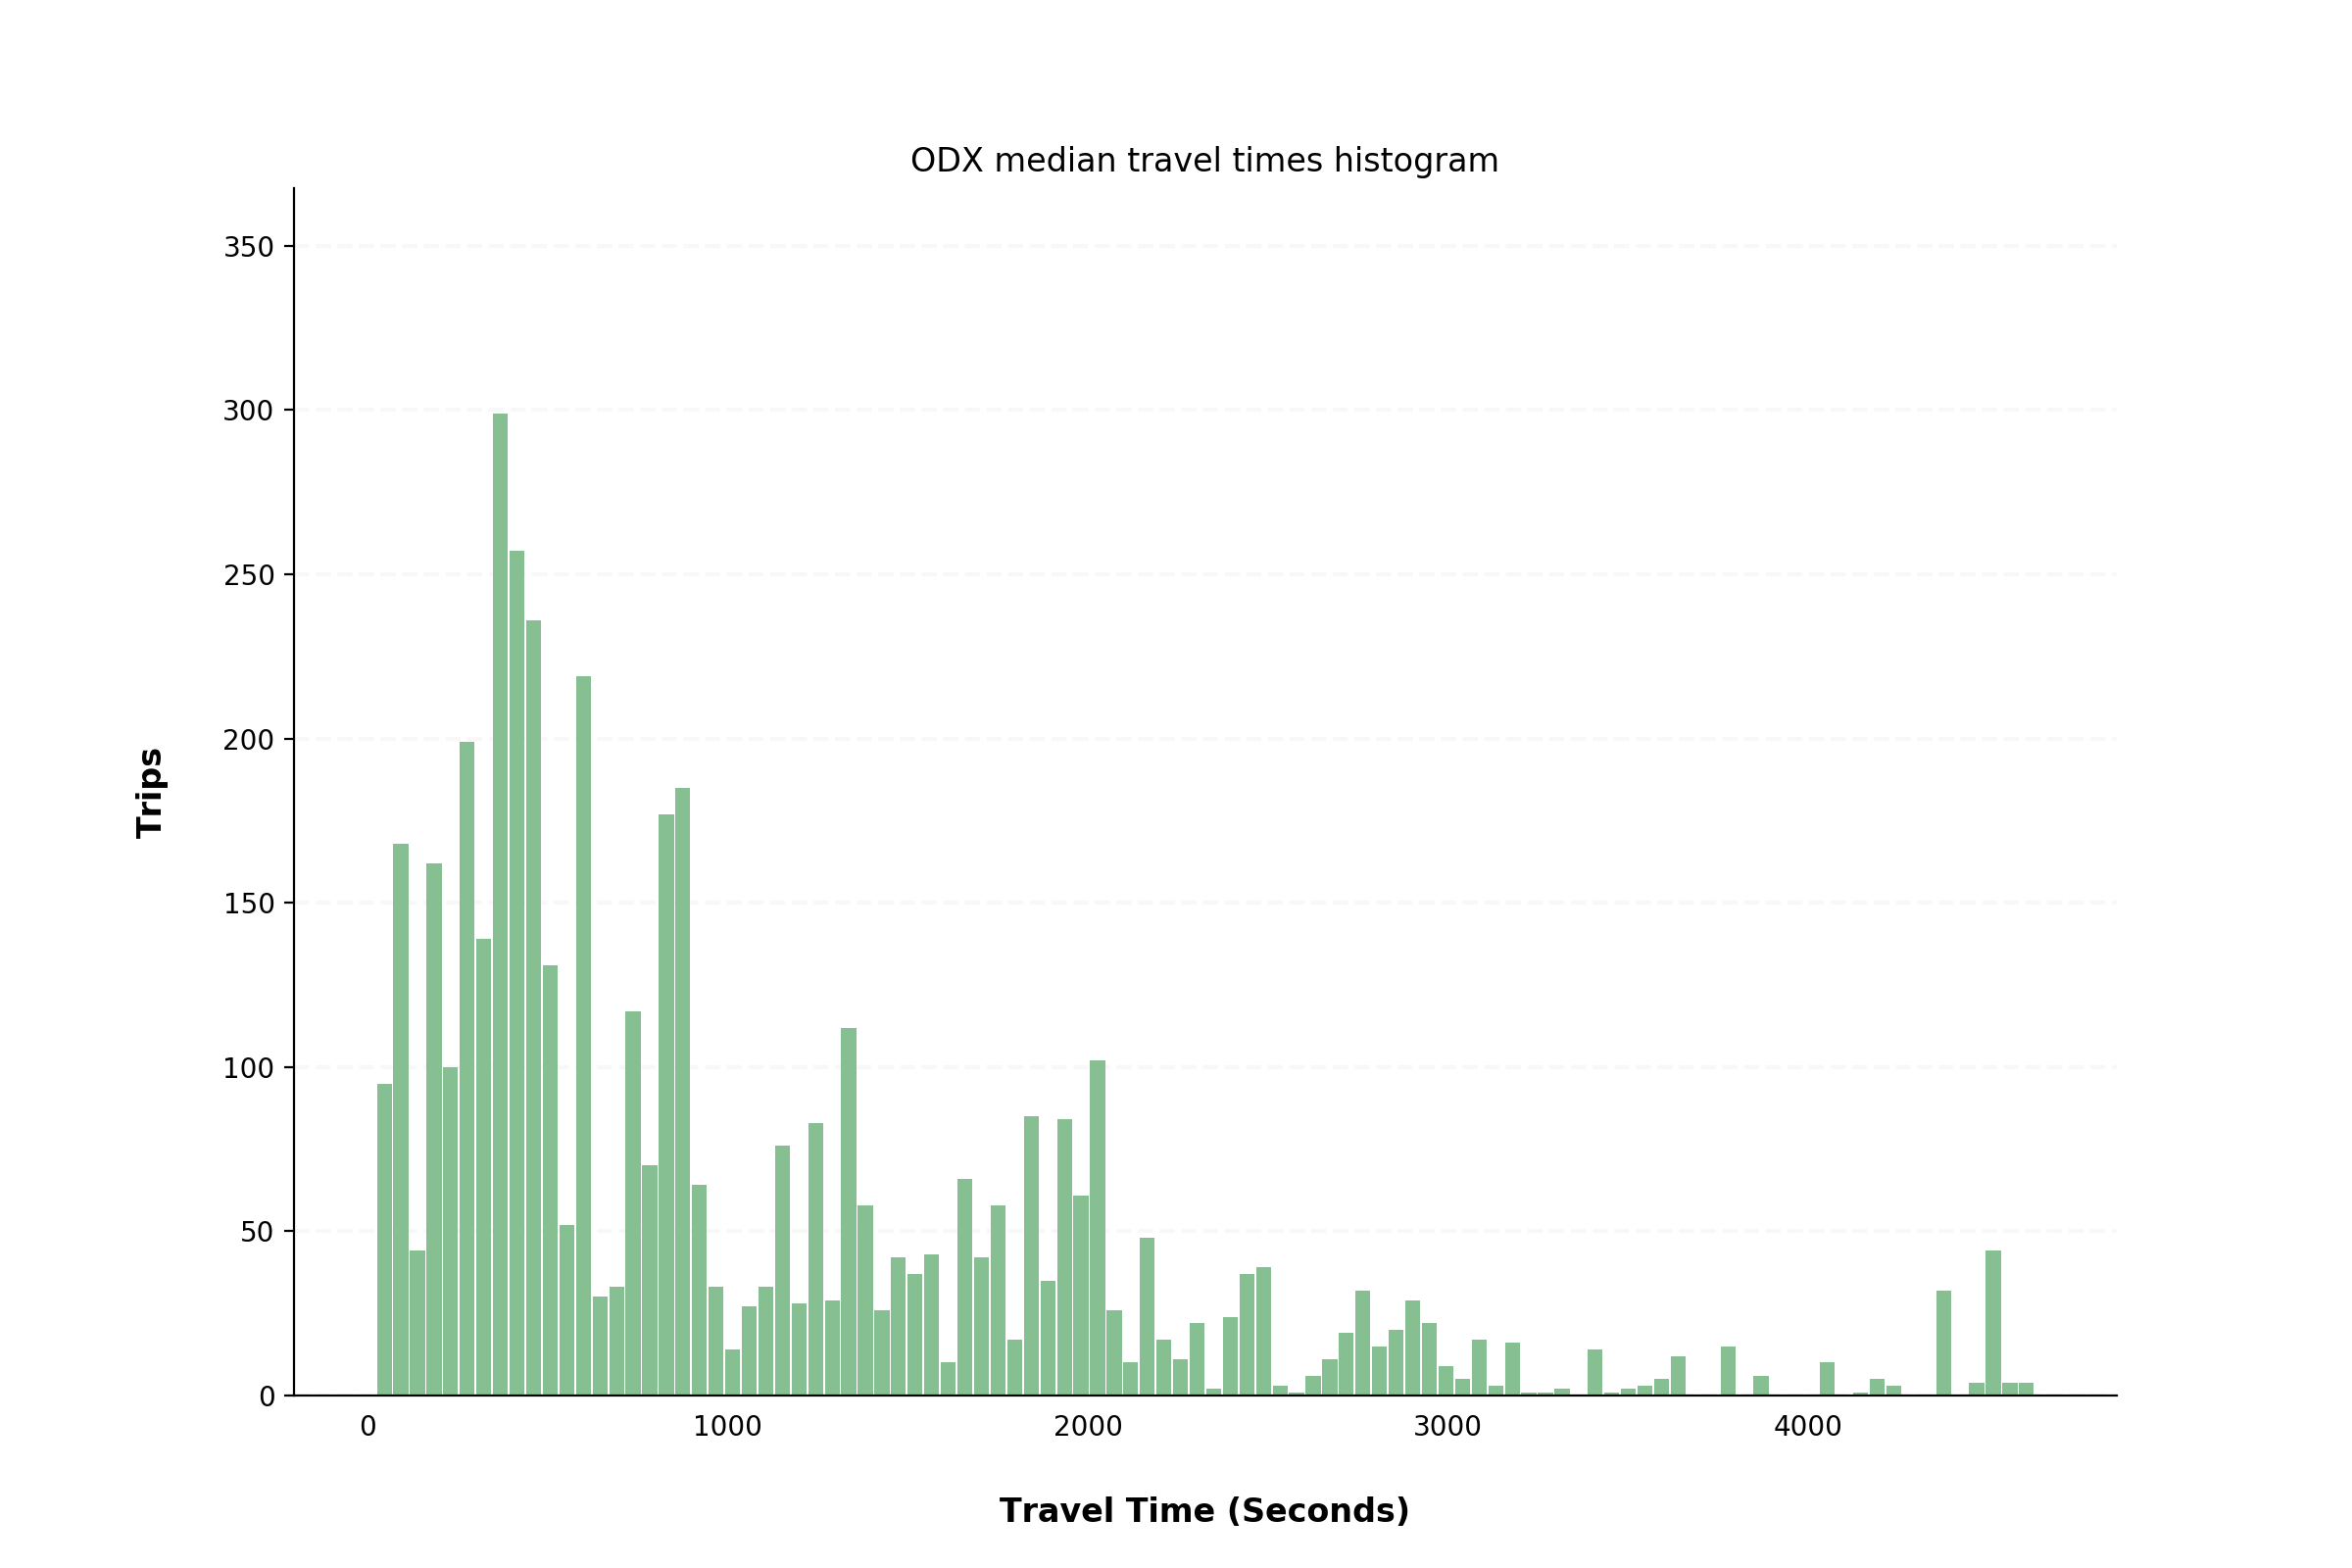

In [100]:
%matplotlib notebook
import matplotlib.pyplot as plt

axis = results.hist(column = 'median_tt', bins=100, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

axis = axis[0]
for x in axis:
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=True, right=False, labelleft=True)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Rename Title
    x.set_title("ODX median travel times histogram")

    # Set x-axis label
    x.set_xlabel("Travel Time (Seconds)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Trips", labelpad=20, weight='bold', size=12)
    
plt.savefig('odx_medianTT_histogram.png', bbox_inches='tight')

#plt.show()


<IPython.core.display.Javascript object>


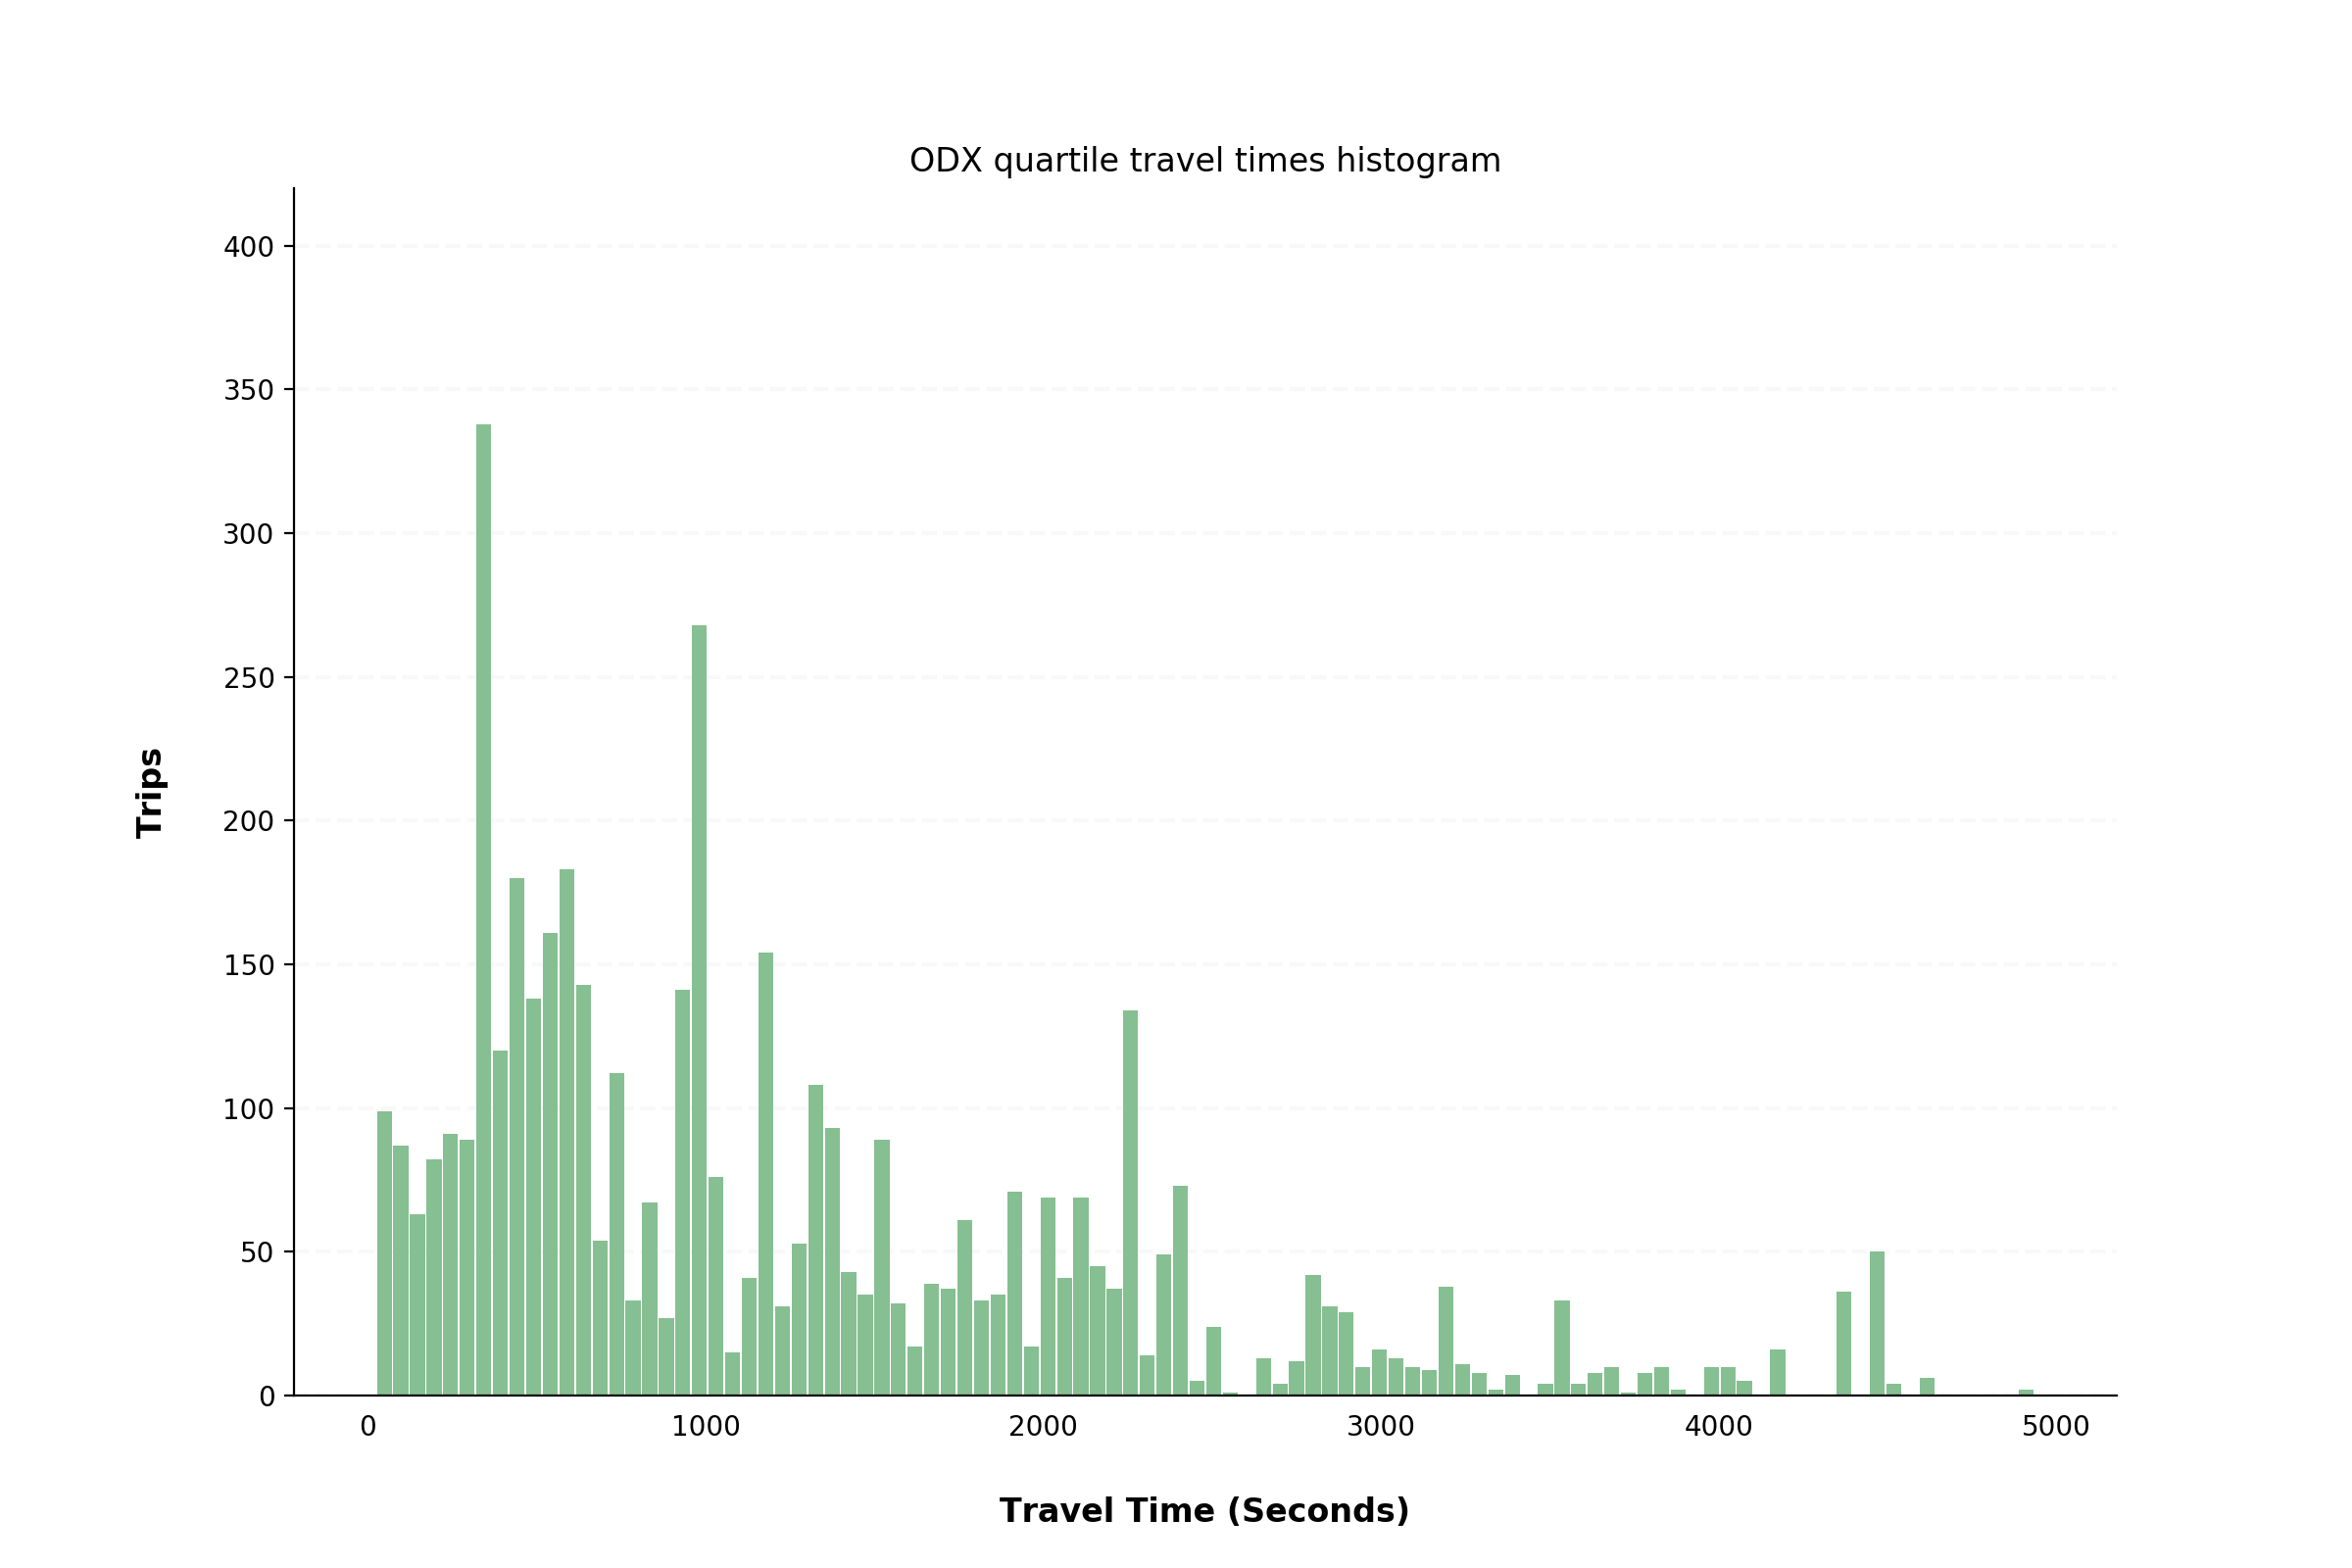

In [101]:
axis = results.hist(column = 'quartile_tt', bins=100, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
axis = axis[0]
for x in axis:
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=True, right=False, labelleft=True)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Rename Title
    x.set_title("ODX quartile travel times histogram")

    # Set x-axis label
    x.set_xlabel("Travel Time (Seconds)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Trips", labelpad=20, weight='bold', size=12)

plt.savefig('ODX_quartileTT_histogram.png', bbox_inches='tight')
#plt.show()